In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow  as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


from sklearn.metrics import mean_absolute_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from tensorflow.keras.callbacks import *
import os

2021-09-07 18:06:36.071303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-07 18:06:36.071341: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
gpus = tf.config.experimental.list_physical_devices('CPU')
print(gpus)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
gpus = tf.config.experimental.list_physical_devices('CPU')
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
frame = pd.read_csv(r'20152018/ausleihen_merged_ohne_nullen.csv')
#frame = pd.read_csv(r'ausleihen_mit_wetter.csv')
df = pd.DataFrame(frame)
df.head()

,year,month,day,hour,count,holidays,weekday,workday,tempC,precipMM,humidity,windspeedKmph,weatherDesc2
0,2015,1,1,2,1,1,3,0,-4,0.0,50,21,Clear
1,2015,1,1,10,3,1,3,0,-1,0.0,37,25,Sunny
2,2015,1,1,11,3,1,3,0,0,0.0,36,24,Sunny
3,2015,1,1,12,2,1,3,0,2,0.0,35,22,Sunny
4,2015,1,1,13,5,1,3,0,2,0.0,37,23,Sunny


In [ ]:
df.dtypes

In [5]:
df = pd.get_dummies(df, columns=['weekday', 'hour','weatherDesc2','month'] )

In [6]:
df = df.drop(['day'],axis=1)

In [7]:
df.head()

,year,count,holidays,workday,tempC,precipMM,humidity,windspeedKmph,weekday_0,weekday_1,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2015,1,1,0,-4,0.0,50,21,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2015,3,1,0,-1,0.0,37,25,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015,3,1,0,0,0.0,36,24,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2015,2,1,0,2,0.0,35,22,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2015,5,1,0,2,0.0,37,23,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#Split Data
y = df['count']
X = df.drop('count',axis=1)

# Train-Test-Split
X_train , X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,shuffle=False  )

In [9]:
X_train.shape

(21274, 92)

In [10]:
ct = make_column_transformer(
 (MinMaxScaler(),["year","humidity","tempC","precipMM","windspeedKmph"]) , remainder="passthrough"
 )

#X_train[['year','tempC','precipMM','humidity']] = MinMaxScaler().fit_transform(X_train[['year','tempC','precipMM','humidity']])


ct.fit(X_train)

x_train_normalized = ct.transform(X_train)

x_test_normalized = ct.transform(X_test)

In [11]:
x_train_normalized

array([[0.        , 0.39759036, 0.25490196, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.24096386, 0.31372549, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.22891566, 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.74698795, 0.41176471, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.75903614, 0.41176471, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.74698795, 0.41176471, ..., 0.        , 0.        ,
        0.        ]])

In [13]:
#create Model structure

model = Sequential()
model.add(Dense(92, kernel_initializer='normal',  activation='relu', input_shape=(92,) ))
#model.add(Dropout(0.3r
model.add(Dense(46, kernel_initializer='normal',activation='relu'))
model.add(Dense(46, kernel_initializer='normal',activation='relu'))
# model.add(Dropout(0.3))
#model.add(Dense(8, kernel_initializer='normal',activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [14]:
model.compile(optimizer= Adam(learning_rate=0.0001),loss='mae', metrics=['mae','mape'])

In [21]:
history = model.fit(x_train_normalized, y_train.values,validation_data =(x_test_normalized, y_test.values), epochs=50 , batch_size=100,shuffle=False   )

Epoch 1/50
213/213 [==============================] - 0s 2ms/step - loss: 3.9911 - mae: 3.9911 - mape: 48.4643 - val_loss: 5.5192 - val_mae: 5.5192 - val_mape: 61.6519
Epoch 2/50
213/213 [==============================] - 0s 2ms/step - loss: 3.9626 - mae: 3.9626 - mape: 47.3703 - val_loss: 5.5167 - val_mae: 5.5167 - val_mape: 61.3608
Epoch 3/50
213/213 [==============================] - 0s 2ms/step - loss: 3.9551 - mae: 3.9551 - mape: 47.3415 - val_loss: 5.5869 - val_mae: 5.5869 - val_mape: 62.5136
Epoch 4/50
213/213 [==============================] - 0s 2ms/step - loss: 3.9600 - mae: 3.9600 - mape: 47.2943 - val_loss: 5.5507 - val_mae: 5.5507 - val_mape: 62.0510
Epoch 5/50
213/213 [==============================] - 0s 2ms/step - loss: 3.9597 - mae: 3.9597 - mape: 47.3672 - val_loss: 5.5307 - val_mae: 5.5307 - val_mape: 61.5716
Epoch 6/50
213/213 [==============================] - 0s 2ms/step - loss: 3.9541 - mae: 3.9541 - mape: 47.3284 - val_loss: 5.5729 - val_mae: 5.5729 - val_mape: 

KeyboardInterrupt: 

In [18]:
model.evaluate(x_test_normalized,y_test.values)

167/167 [==============================] - 0s 761us/step - loss: 5.3852 - mae: 5.3852 - mape: 60.9911


[5.38524866104126, 5.38524866104126, 60.99112319946289]

In [22]:
testhist = model.predict(x_test_normalized)


In [23]:
y_test.mean()

15.869900357210001

In [24]:
np.array(X_test.iloc[0])

array([2.018e+03, 0.000e+00, 1.000e+00, 4.000e+00, 0.000e+00, 7.700e+01,
       9.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 

In [25]:
y2 = pd.DataFrame(y_test)

In [26]:
y2["predict"] = testhist


In [ ]:
y2

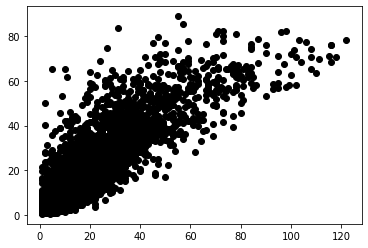

In [27]:
plt.scatter(y2['count'],y2['predict'],label='predict' , color = 'black' )
plt.show()

In [ ]:
plt.figure(figsize =(400, 20))
plt.plot(y2.index,y2['count'],label='real' , color = 'royalblue' )
plt.plot(y2.index,y2['predict'],label='predict' , color = 'black' )
plt.savefig( 'test.jpg',bbox_inches='tight', dpi=150)
plt.show()

In [31]:
y1 = pd.DataFrame(y_train)

In [ ]:
plt.figure(figsize =(400, 20))
plt.plot(y1.index,y1['count1'],label='real' , color = 'royalblue' )

In [ ]:
y_train.values

In [50]:
# Plot
import plotly.express as px
fig = px.scatter(
    x=y2['predict'],
    y=y_test,
    labels={'x':"Predicted", 'y':'Actual'},
    width=700,
    height=700
)

fig.show()

In [35]:
from sklearn.metrics import mean_squared_error
def get_rmse(reg, model_name):
    """Print the score for the model passed in argument and retrun scores for the train/test sets"""
    
    y_train_pred, y_pred = reg.predict(X_train), reg.predict(X_test)
    rmse_train, rmse_test = np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_test, y_pred))
    print(model_name, f'\t - RMSE on Training  = {rmse_train:.2f} / RMSE on Test = {rmse_test:.2f}')
    
    return rmse_train, rmse_test

In [58]:
#Ramdom Forest
rf = RandomForestRegressor(n_estimators=100).fit(x_train_normalized,y_train)
_, _ = get_rmse(rf, 'random forrest')

rf_pred = rf.predict(x_test_normalized)

random forrest 	 - RMSE on Training  = 17.21 / RMSE on Test = 15.80


In [54]:
gb = GradientBoostingRegressor(n_estimators=100).fit(x_train_normalized, y_train)
_, _ = get_rmse(gb, 'gb')

gb_pred = gb.predict(x_test_normalized)

gb 	 - RMSE on Training  = 16.43 / RMSE on Test = 16.31


In [44]:
#XGBoost
model = XGBRegressor()
model.fit(x_train_normalized,y_train.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
y_pred = model.predict(x_test_normalized)
_, _ = get_rmse(model, 'XGB')

XGB 	 - RMSE on Training  = 16.80 / RMSE on Test = 17.83


In [59]:
# Plot
import plotly.express as px
fig = px.scatter(
    x=rf_pred,
    y=y_test.values,
    labels={'x':"Predicted", 'y':'Actual'},
    width=700,
    height=700
)

fig.show()